# Regridding datasets

Options:

- Interpolating using Xarray
  - <https://docs.xarray.dev/en/stable/user-guide/interpolation.html>
- Reproject match using Rioxarray
  - <https://corteva.github.io/rioxarray/stable/examples/reproject_match.html>
  - <https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling>
- xESMF's regridder
  - <https://xesmf.readthedocs.io/en/latest/notebooks/Dataset.html>

In [1]:
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import rasterio as rio
import xarray as xr
import xesmf as xe
import climag.plot_configs as cplt

In [2]:
def plot_map(data, var, x, y, transform, cmap="Spectral_r", contour=False):
    """
    Helper function for plotting maps
    """

    plt.figure(figsize=(9, 7))
    ax = plt.axes(projection=cplt.projection_hiresireland)
    if contour:
        data.isel(time=180)[var].plot.contourf(
            ax=ax,
            x=x,
            y=y,
            levels=10,
            robust=True,
            transform=transform,
            cmap=cmap,
        )
    else:
        data.isel(time=180)[var].plot(
            ax=ax,
            x=x,
            y=y,
            levels=10,
            robust=True,
            transform=transform,
            cmap=cmap,
        )
    ax.gridlines(
        draw_labels=dict(bottom="x", left="y"),
        color="lightslategrey",
        linewidth=0.5,
        x_inline=False,
        y_inline=False,
    )
    ax.coastlines(resolution="10m", color="darkslategrey", linewidth=0.75)
    ax.set_title(str(data.isel(time=180)["time"].values))
    plt.tight_layout()
    plt.show()

## Higher resolution observational dataset - MERA

In [3]:
obs = os.path.join(
    "data", "ModVege", "MERA", "modvege_IE_MERA_FC3hr_3_day_1989.nc"
)

In [4]:
obs = xr.open_dataset(obs, decode_coords="all")

In [5]:
# reassign projection
obs.rio.write_crs(cplt.projection_lambert_conformal, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 365)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 ...
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 1989-01-01 ... 1989-12-31
    spatial_ref        int64 0
Data variables: (12/24)
    bm_gv              (time, y, x) float32 ...
    bm_gr              (time, y, x) float32 ...
    bm_dv              (time, y, x) float32 ...
    bm_dr              (time, y, x) float32 ...
    age_gv             (time, y, x) float32 ...
    age_gr             (time, y, x) float32 ...
    ...                 ...
    sen_gv             (time, y, x) float32 ...
    sen_gr             (time, y, x) float32 ...
    abs_dv             (time, y, x) float32 ...
    abs_dr             (time, y, x) float32 ...
    omd_gv             (time, y, x) float32 ...
    omd_gr             (time, y, x) float32 ...
Attributes:
    creation_date:  2023-03-26 08:56:21.004015+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_MERA_FC3hr_3_day

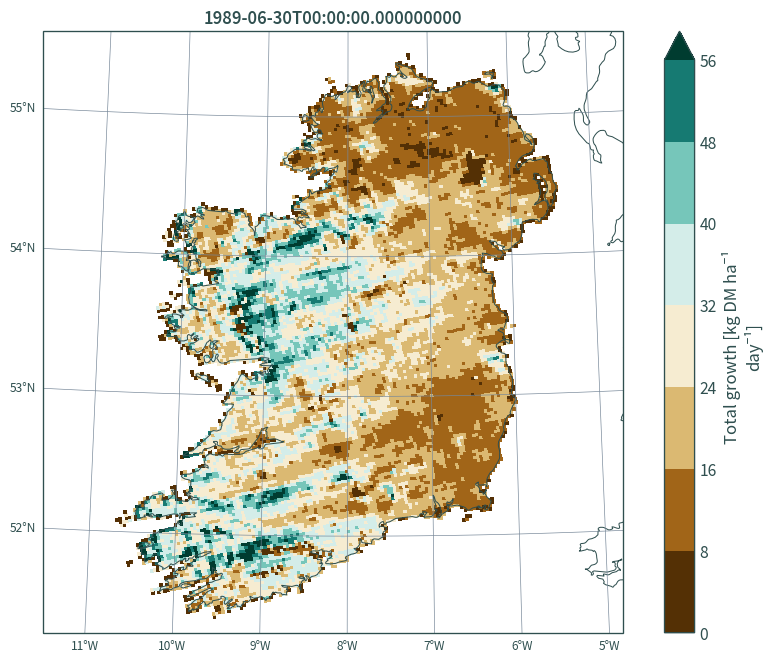

In [6]:
plot_map(obs, "gro", "x", "y", cplt.projection_lambert_conformal, "BrBG")

## Lower resolution climate model dataset - EURO-CORDEX

In [7]:
clim = os.path.join(
    "data",
    "ModVege",
    "EURO-CORDEX",
    "historical",
    "EC-EARTH",
    "modvege_IE_EURO-CORDEX_RCA4_EC-EARTH_historical_1989.nc",
)

In [8]:
clim = xr.open_dataset(clim, decode_coords="all")

In [9]:
clim

<xarray.Dataset>
Dimensions:       (rlat: 33, rlon: 37, time: 365, bnds: 2)
Coordinates:
    lat           (rlat, rlon) float64 ...
    lon           (rlat, rlon) float64 ...
  * rlat          (rlat) float64 3.685 3.795 3.905 4.015 ... 6.985 7.095 7.205
  * rlon          (rlon) float64 -17.27 -17.16 -17.05 ... -13.53 -13.41 -13.3
  * time          (time) datetime64[ns] 1989-01-01T12:00:00 ... 1989-12-31T12...
    height        float64 ...
    rotated_pole  |S1 ...
    time_bnds     (time, bnds) datetime64[ns] ...
    spatial_ref   int64 ...
Dimensions without coordinates: bnds
Data variables: (12/24)
    bm_gv         (time, rlat, rlon) float32 ...
    bm_gr         (time, rlat, rlon) float32 ...
    bm_dv         (time, rlat, rlon) float32 ...
    bm_dr         (time, rlat, rlon) float32 ...
    age_gv        (time, rlat, rlon) float32 ...
    age_gr        (time, rlat, rlon) float32 ...
    ...            ...
    sen_gv        (time, rlat, rlon) float32 ...
    sen_gr        (time, rlat, rlon) float32 ...
    abs_dv        (time, rlat, rlon) float32 ...
    abs_dr        (time, rlat, rlon) float32 ...
    omd_gv        (time, rlat, rlon) float32 ...
    omd_gr        (time, rlat, rlon) float32 ...
Attributes:
    creation_date:  2023-03-11 01:33:28.094139+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_EURO-CORDEX_RCA4_EC-EARTH_historical

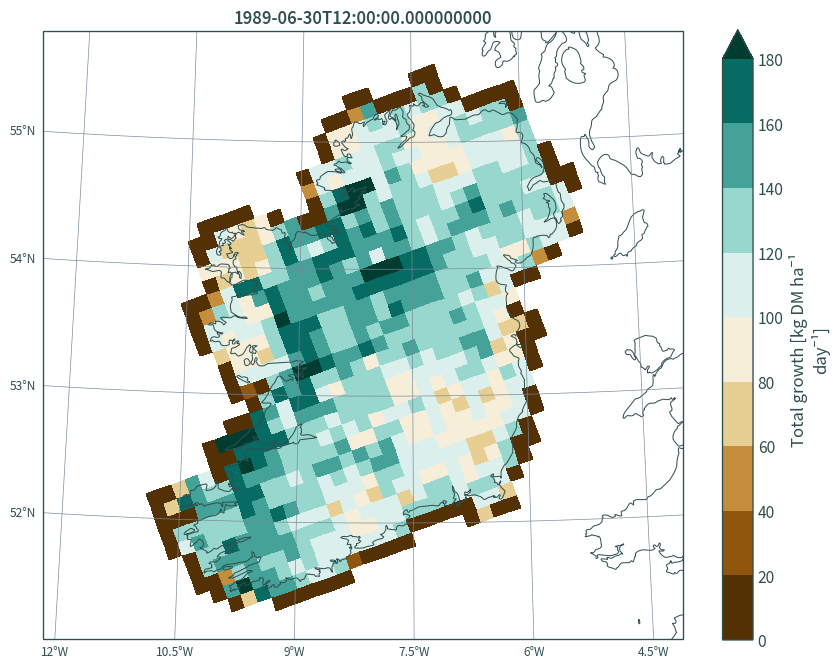

In [10]:
plot_map(clim, "gro", "rlon", "rlat", cplt.projection_eurocordex, "BrBG")

## xESMF's Regridder

In [11]:
# drop unnecessary coordinates and normalise to keep only date in time
clim2 = clim.drop(["lat", "lon", "time_bnds"])
clim2["time"] = clim2.indexes["time"].normalize()

In [12]:
# reproject to lat/lon degrees
obs2 = obs.rio.reproject(ccrs.PlateCarree())
clim2 = clim2.rio.reproject(ccrs.PlateCarree())

In [13]:
# rename dims
obs2 = obs2.rename({"x": "lon", "y": "lat"})
clim2 = clim2.rename({"x": "lon", "y": "lat"})

In [14]:
obs2

<xarray.Dataset>
Dimensions:            (lon: 211, lat: 130, time: 365)
Coordinates:
  * lon                (lon) float64 -11.79 -11.75 -11.72 ... -4.839 -4.806
  * lat                (lat) float64 55.58 55.55 55.51 ... 51.36 51.32 51.29
    Lambert_Conformal  int64 0
    height             float64 0.0
  * time               (time) datetime64[ns] 1989-01-01 ... 1989-12-31
    spatial_ref        int64 0
Data variables: (12/24)
    bm_gv              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bm_gr              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bm_dv              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bm_dr              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    age_gv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    age_gr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    ...                 ...
    sen_gv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    sen_gr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    abs_dv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    abs_dr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    omd_gv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    omd_gr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    creation_date:  2023-03-26 08:56:21.004015+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_MERA_FC3hr_3_day

In [15]:
clim2

<xarray.Dataset>
Dimensions:       (lon: 48, lat: 27, time: 365)
Coordinates:
  * lon           (lon) float64 -12.41 -12.24 -12.06 ... -4.5 -4.324 -4.148
  * lat           (lat) float64 55.77 55.6 55.42 55.25 ... 51.55 51.38 51.2
    height        float64 2.0
    rotated_pole  |S1 b''
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
    spatial_ref   int64 0
Data variables: (12/24)
    bm_gv         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    bm_gr         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    bm_dv         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    bm_dr         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    age_gv        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    age_gr        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...            ...
    sen_gv        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    sen_gr        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    abs_dv        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    abs_dr        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    omd_gv        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    omd_gr        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    creation_date:  2023-03-11 01:33:28.094139+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_EURO-CORDEX_RCA4_EC-EARTH_historical

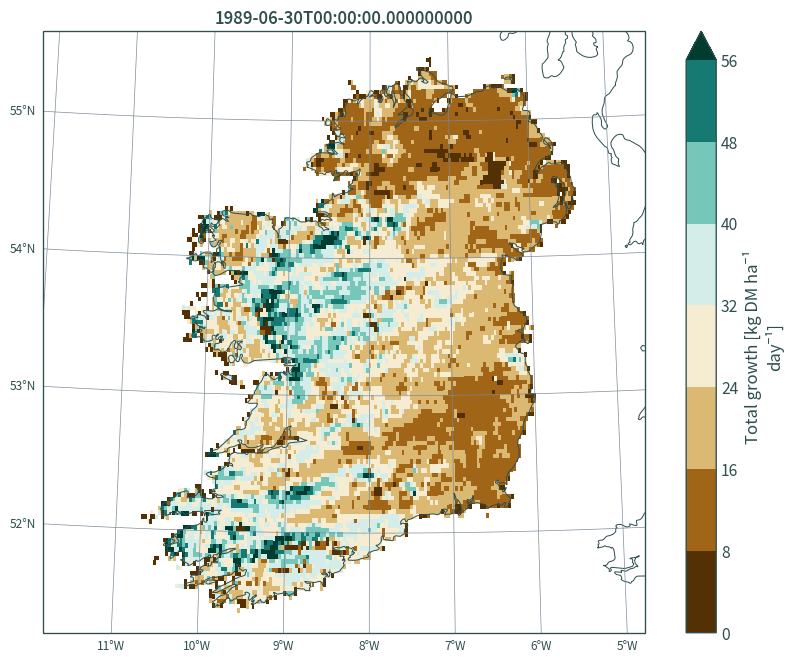

In [16]:
plot_map(obs2, "gro", "lon", "lat", ccrs.PlateCarree(), "BrBG")

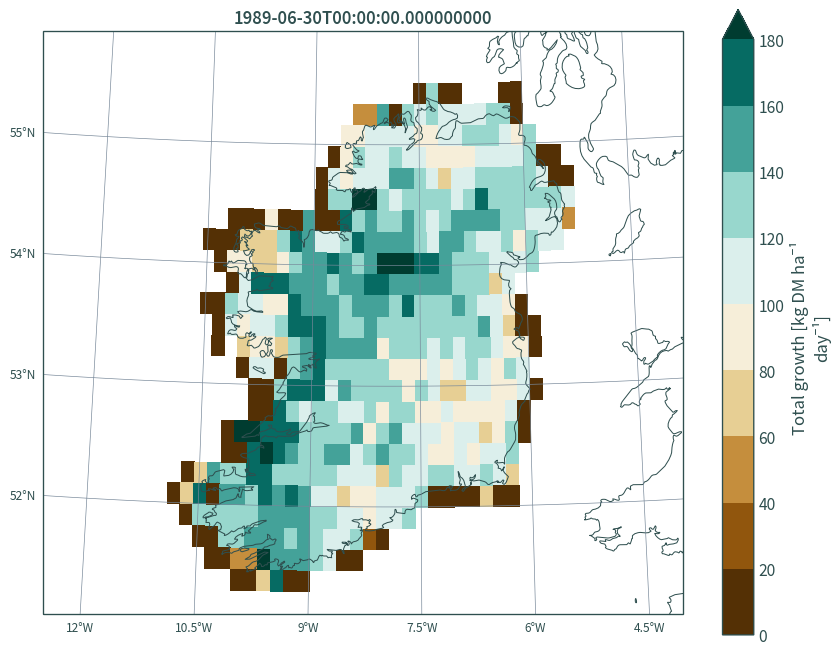

In [17]:
plot_map(clim2, "gro", "lon", "lat", ccrs.PlateCarree(), "BrBG")

In [18]:
regridder = xe.Regridder(clim2, obs2, "bilinear")

In [19]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_27x48_130x211.nc 
Reuse pre-computed weights? False 
Input grid shape:           (27, 48) 
Output grid shape:          (130, 211) 
Periodic in longitude?      False

In [20]:
clim2 = regridder(clim2)

In [21]:
clim2

<xarray.Dataset>
Dimensions:            (time: 365, lat: 130, lon: 211)
Coordinates:
    height             float64 0.0
    rotated_pole       |S1 b''
  * time               (time) datetime64[ns] 1989-01-01 ... 1989-12-31
    spatial_ref        int64 0
    Lambert_Conformal  int64 0
  * lon                (lon) float64 -11.79 -11.75 -11.72 ... -4.839 -4.806
  * lat                (lat) float64 55.58 55.55 55.51 ... 51.36 51.32 51.29
Data variables: (12/24)
    bm_gv              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bm_gr              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bm_dv              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bm_dr              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    age_gv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    age_gr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    ...                 ...
    sen_gv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    sen_gr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    abs_dv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    abs_dr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    omd_gv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    omd_gr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    regrid_method:  bilinear

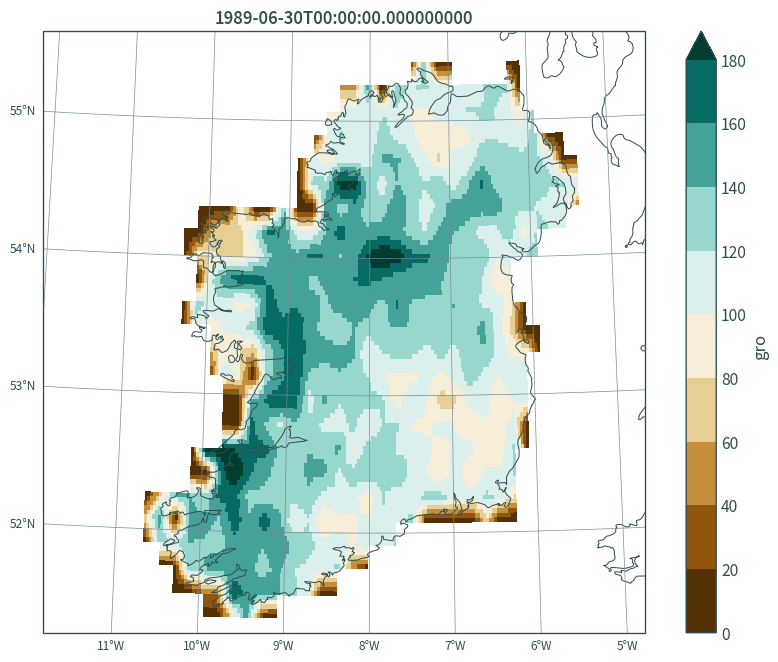

In [22]:
plot_map(clim2, "gro", "lon", "lat", ccrs.PlateCarree(), "BrBG")

### Difference

In [23]:
diff = clim2 - obs2

In [24]:
diff

<xarray.Dataset>
Dimensions:            (time: 365, lon: 211, lat: 130)
Coordinates:
    height             float64 0.0
    rotated_pole       |S1 b''
  * time               (time) datetime64[ns] 1989-01-01 ... 1989-12-31
    spatial_ref        int64 0
    Lambert_Conformal  int64 0
  * lon                (lon) float64 -11.79 -11.75 -11.72 ... -4.839 -4.806
  * lat                (lat) float64 55.58 55.55 55.51 ... 51.36 51.32 51.29
Data variables: (12/24)
    bm_gv              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bm_gr              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bm_dv              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bm_dr              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    age_gv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    age_gr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    ...                 ...
    sen_gv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    sen_gr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    abs_dv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    abs_dr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    omd_gv             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    omd_gr             (time, lat, lon) float32 nan nan nan nan ... nan nan nan

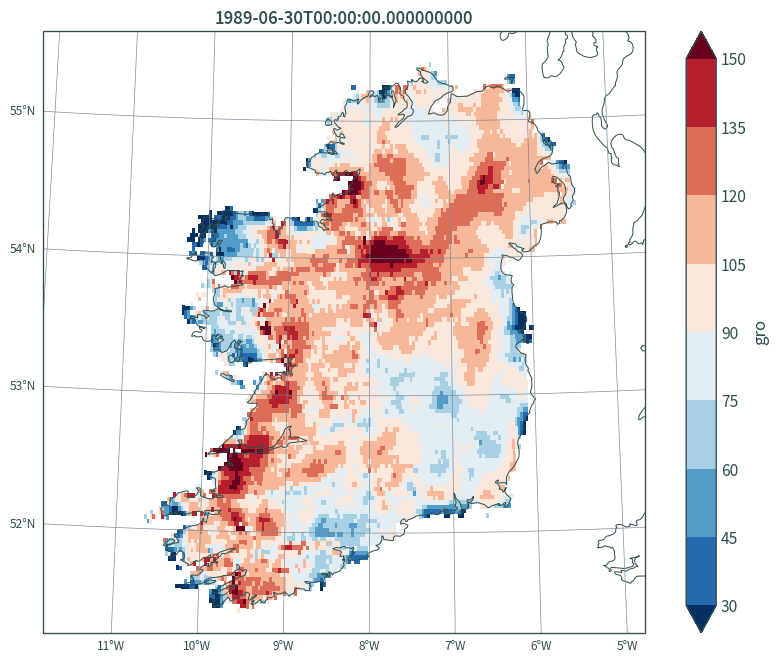

In [25]:
plot_map(diff, "gro", "lon", "lat", ccrs.PlateCarree(), "RdBu_r")

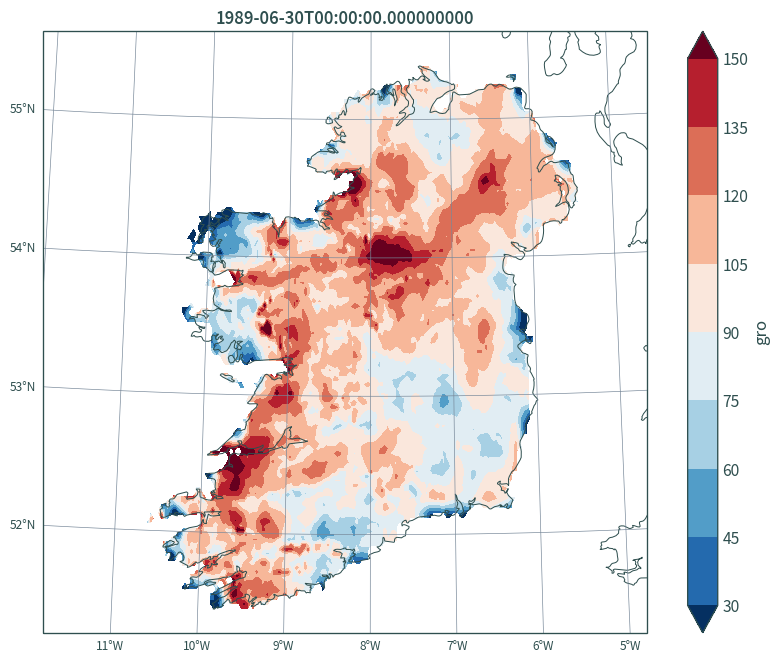

In [26]:
plot_map(diff, "gro", "lon", "lat", ccrs.PlateCarree(), "RdBu_r", contour=True)

## Xarray's interp_like

In [27]:
# drop unnecessary coordinates and normalise to keep only date in time
clim2 = clim.drop(["lat", "lon", "time_bnds"])
clim2["time"] = clim2.indexes["time"].normalize()

# reproject to observational data's CRS
clim2 = clim2.rio.reproject(cplt.projection_lambert_conformal)
# interpolate
clim2 = clim2.interp_like(obs)

In [28]:
clim2

<xarray.Dataset>
Dimensions:       (time: 365, y: 166, x: 158)
Coordinates:
    height        float64 2.0
    rotated_pole  |S1 b''
    spatial_ref   int64 0
  * x             (x) float64 4.15e+05 4.175e+05 4.2e+05 ... 8.05e+05 8.075e+05
  * y             (y) float64 4.075e+05 4.1e+05 4.125e+05 ... 8.175e+05 8.2e+05
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 1989-12-31
Data variables: (12/24)
    bm_gv         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    bm_gr         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    bm_dv         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    bm_dr         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    age_gv        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    age_gr        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    ...            ...
    sen_gv        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    sen_gr        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    abs_dv        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    abs_dr        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    omd_gv        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    omd_gr        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    creation_date:  2023-03-11 01:33:28.094139+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_EURO-CORDEX_RCA4_EC-EARTH_historical

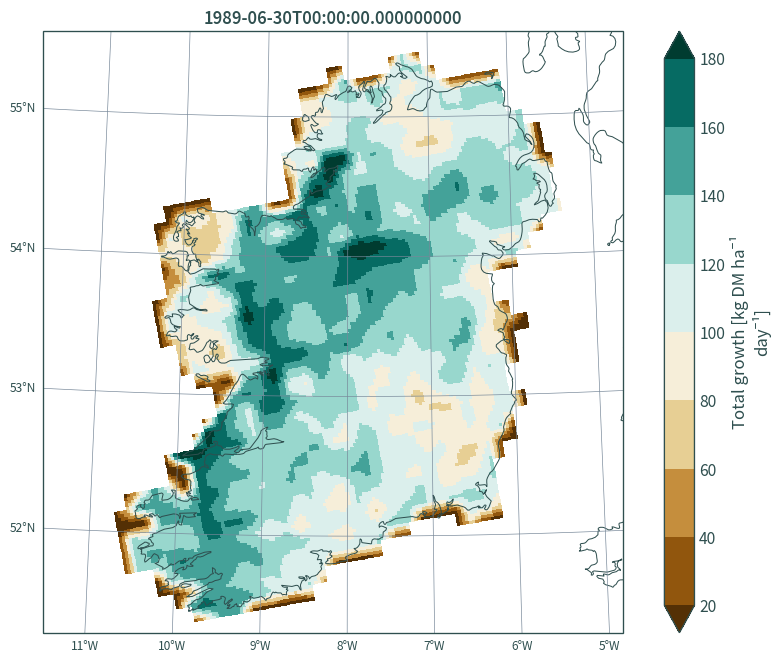

In [29]:
plot_map(clim2, "gro", "x", "y", cplt.projection_lambert_conformal, "BrBG")

### Difference

In [30]:
diff = clim2 - obs

In [31]:
diff

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 365)
Coordinates:
    rotated_pole       |S1 b''
    spatial_ref        int64 0
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
  * time               (time) datetime64[ns] 1989-01-01 ... 1989-12-31
    Lambert_Conformal  int64 0
Data variables: (12/24)
    bm_gv              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    bm_gr              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    bm_dv              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    bm_dr              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    age_gv             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    age_gr             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    ...                 ...
    sen_gv             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    sen_gr             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    abs_dv             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    abs_dr             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    omd_gv             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    omd_gr             (time, y, x) float64 nan nan nan nan ... nan nan nan nan

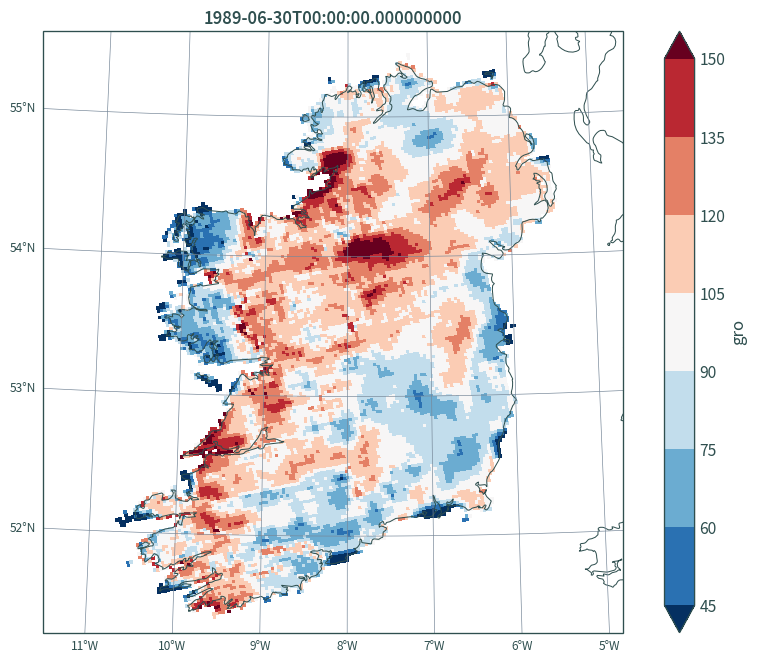

In [32]:
plot_map(diff, "gro", "x", "y", cplt.projection_lambert_conformal, "RdBu_r")

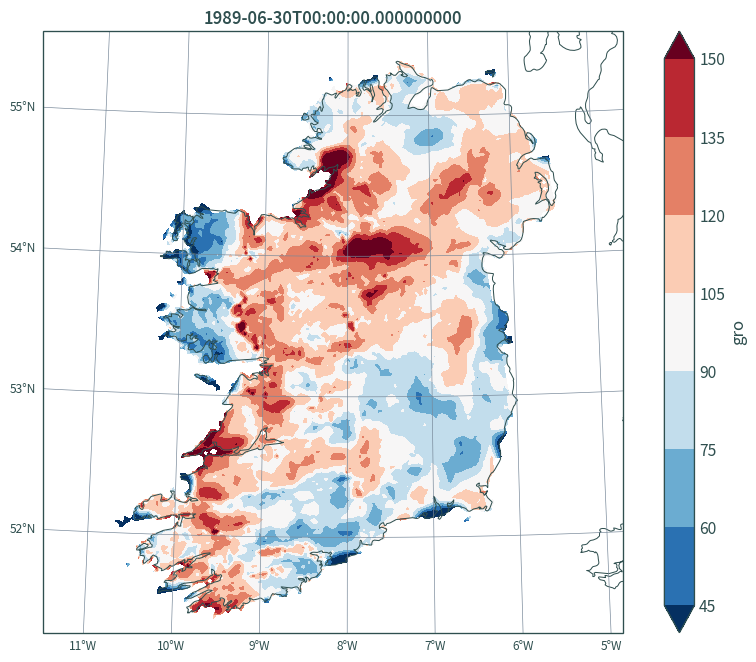

In [33]:
plot_map(diff, "gro", "x", "y", cplt.projection_lambert_conformal, "RdBu_r", contour=True)

## Rioxarray's reproject_match

In [23]:
# drop unnecessary coordinates and normalise to keep only date in time
clim2 = clim.drop(["lat", "lon", "time_bnds"])
clim2["time"] = clim2.indexes["time"].normalize()

clim2 = clim2.rename({"rlon": "x", "rlat": "y"})
clim2 = clim2.rio.reproject_match(
    obs, resampling=rio.enums.Resampling.bilinear
)
clim2 = clim2.assign_coords({"x": obs["x"], "y": obs["y"]})

In [24]:
clim2

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 365)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    rotated_pole       |S1 b''
  * time               (time) datetime64[ns] 1989-01-01 ... 1989-12-31
    height             float64 0.0
    spatial_ref        int64 0
    Lambert_Conformal  int64 0
Data variables: (12/24)
    bm_gv              (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    bm_gr              (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    bm_dv              (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    bm_dr              (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    age_gv             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    age_gr             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                 ...
    sen_gv             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    sen_gr             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    abs_dv             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    abs_dr             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    omd_gv             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    omd_gr             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    creation_date:  2023-03-11 01:33:28.094139+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_EURO-CORDEX_RCA4_EC-EARTH_historical

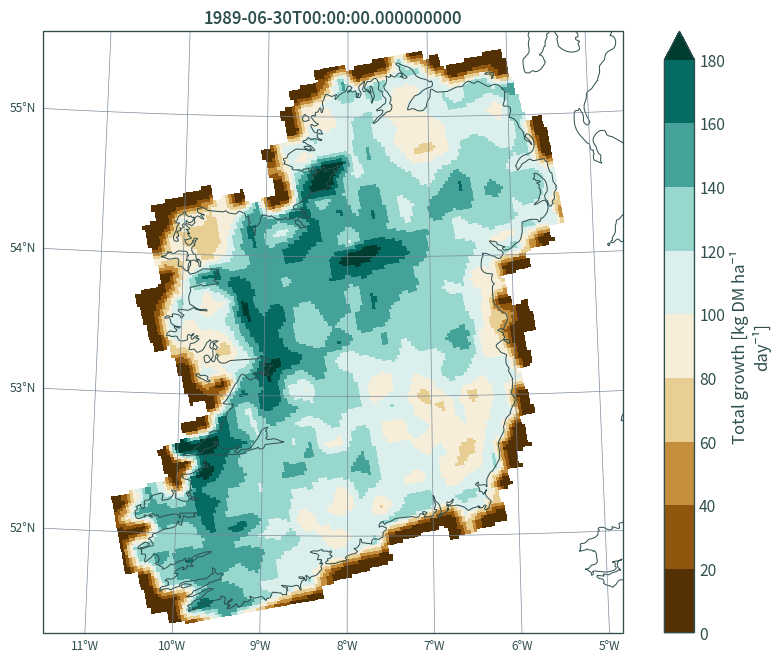

In [25]:
plot_map(clim2, "gro", "x", "y", cplt.projection_lambert_conformal, "BrBG")

### Difference

In [26]:
diff = clim2 - obs

In [27]:
diff

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 365)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    rotated_pole       |S1 b''
  * time               (time) datetime64[ns] 1989-01-01 ... 1989-12-31
    height             float64 0.0
    spatial_ref        int64 0
    Lambert_Conformal  int64 0
Data variables: (12/24)
    bm_gv              (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    bm_gr              (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    bm_dv              (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    bm_dr              (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    age_gv             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    age_gr             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                 ...
    sen_gv             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    sen_gr             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    abs_dv             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    abs_dr             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    omd_gv             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    omd_gr             (time, y, x) float32 nan nan nan nan ... nan nan nan nan

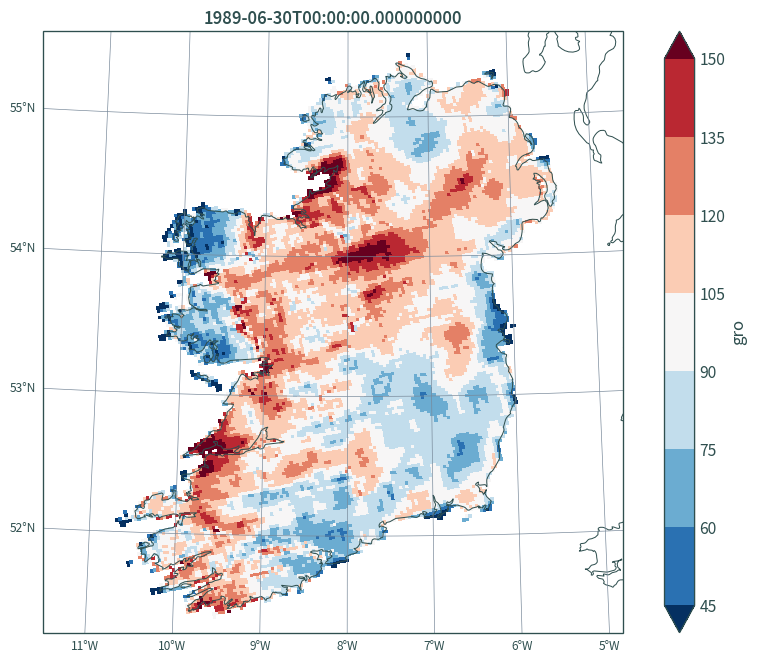

In [28]:
plot_map(diff, "gro", "x", "y", cplt.projection_lambert_conformal, "RdBu_r")

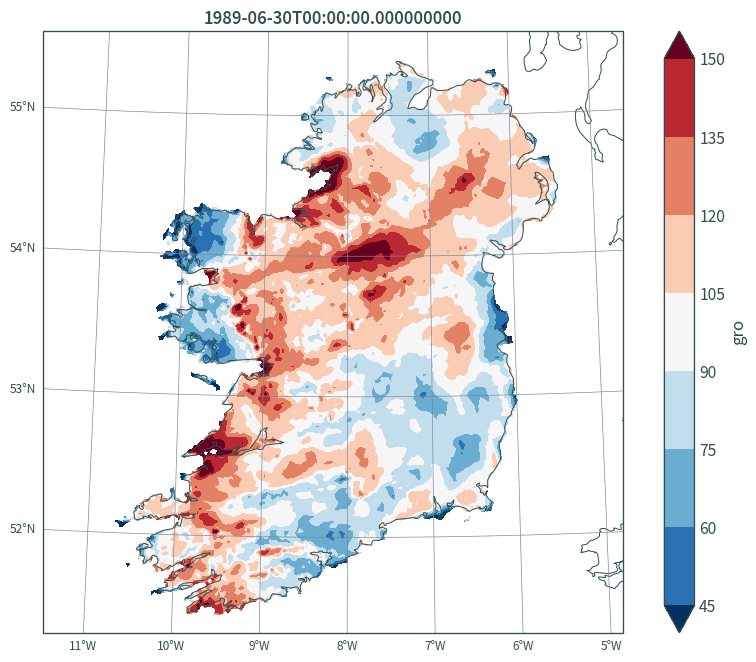

In [29]:
plot_map(diff, "gro", "x", "y", cplt.projection_lambert_conformal, "RdBu_r", contour=True)